In [1]:
import neptune.new as neptune
myProject = 'aligator/RNN'
project = neptune.init(api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzOTM1NWZiMC05OTkwLTRlNmQtOTcxMi05ODc5NWIwZGRiMTkifQ==",
                        project=myProject) 
project.stop()


/tmp/ipykernel_1638/2768557309.py:3: NeptuneDeprecationWarning: `init` is deprecated, use `init_run` instead. We'll end support of it in `neptune-client==1.0.0`.
  project = neptune.init(api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzOTM1NWZiMC05OTkwLTRlNmQtOTcxMi05ODc5NWIwZGRiMTkifQ==",


https://app.neptune.ai/aligator/RNN/e/RNN-52


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/help/nvml_error/


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 9 operations to synchronize with Neptune. Do not kill this process.
All 9 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aligator/RNN/e/RNN-52


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import LSTM, GRU, SimpleRNN
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.datasets import imdb
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam

2022-12-27 07:30:28.381426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 07:30:28.449491: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-27 07:30:28.451740: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-27 07:30:28.451750: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [3]:
max_features = 20000
maxlen = 100  
batch_size = 2500
n_epochs = 10
print("Loading data...")
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Example:')
print(X_train[:1])

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)



Loading data...
25000 train sequences
25000 test sequences
Example:
[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 1

In [4]:
def getBatchGradWgts(grads, wgts, lossVal,
                      gradHist, lossHist, wgtsHist,
                      recordWeight=True, npt_exp=None):
    dataGrad, dataWeight = {}, {}
    ## batch update 'weights'
    for wgt, grad in zip(wgts, grads):
        if '/kernel:' not in wgt.name:
            continue
        layerName = wgt.name.split("/")[0]
        dataGrad[layerName] = grad.numpy()
        dataWeight[layerName] = wgt.numpy()
        ## Log in Neptune
        if npt_exp:
            npt_exp[f'MeanGrads{layerName.upper()}'].log(np.mean(grad.numpy()))
            npt_exp[f'MeanWgtBatch{layerName.upper()}'].log(np.mean(wgt.numpy()))

    gradHist.append(dataGrad)
    lossHist.append(lossVal.numpy())
    if recordWeight:
        wgtsHist.append(dataWeight)


In [5]:
def fitModel(X, y, model, optimizer,
              n_epochs=n_epochs, curBatch_size=batch_size, npt_exp=None):

    lossFunc = tf.keras.losses.BinaryCrossentropy()
    subData = tf.data.Dataset.from_tensor_slices((X, y))
    subData = subData.shuffle(buffer_size=42).batch(curBatch_size)

    gradHist, lossHist, wgtsHist = [], [], []

    for epoch in range(n_epochs):
        print(f'== Starting epoch {epoch} ==')
        for step, (x_batch, y_batch) in enumerate(subData):
            with tf.GradientTape() as tape:
                ## Predict with the model and calculate loss
                yPred = model(x_batch, training=True)
                lossVal = lossFunc(y_batch, yPred)

            ## Calculate gradients using tape and update the weights
            grads = tape.gradient(lossVal, model.trainable_weights)
            wgts = model.trainable_weights
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            ## Save the Interaction#5 from each epoch
            if step == 5:
                getBatchGradWgts(gradHist=gradHist, lossHist=lossHist, wgtsHist=wgtsHist,
                                 grads=grads, wgts=wgts, lossVal=lossVal, npt_exp=npt_exp)
                if npt_exp:
                    npt_exp['BatchLoss'].log(lossVal)

    getBatchGradWgts(gradHist=gradHist, lossHist=lossHist, wgtsHist=wgtsHist,
                     grads=grads, wgts=wgts, lossVal=lossVal, npt_exp=npt_exp)
    return gradHist, lossHist, wgtsHist

In [6]:
def gradientsVis(curGradHist, curLossHist, modelName):
    fig, ax = plt.subplots(1, 1, sharex=True, constrained_layout=True, figsize=(7,5))
    ax.set_title(f"Mean gradient {modelName}")
    for layer in curGradHist[0]:
        if layer == 'layer4':
            ax.plot(range(len(curGradHist)), [gradList[layer].mean() for gradList in curGradHist], label=f'Layer_{"Recurrent"}')
    ax.legend()
    return fig

https://app.neptune.ai/aligator/RNN/e/RNN-56
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Build model...
Train...
== Starting epoch 0 ==
== Starting epoch 1 ==
== Starting epoch 2 ==
== Starting epoch 3 ==
== Starting epoch 4 ==
== Starting epoch 5 ==
== Starting epoch 6 ==
== Starting epoch 7 ==
== Starting epoch 8 ==
== Starting epoch 9 ==
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.
All 6 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aligator/RNN/e/RNN-56


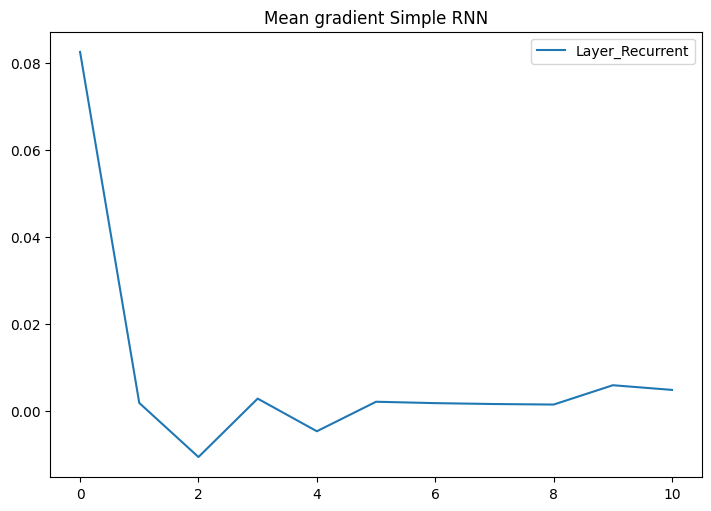

In [10]:
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
npt_exp = neptune.init(    
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzOTM1NWZiMC05OTkwLTRlNmQtOTcxMi05ODc5NWIwZGRiMTkifQ==",
    project=myProject, 
    name='SimpleRNN', 
    tags=['vanishingGradients'])
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen,name="layer1"))
model.add(SimpleRNN(128, activation='sigmoid',name="layer2"))  
model.add(Dropout(0.5, name="layer3"))
model.add(Dense(1,name="layer4"))
model.add(Activation('sigmoid', name="layer5"))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam')
opt = Adam(learning_rate=0.01)
print("Train...")
#model.fit(X_train, y_train, batch_size=batch_size, epochs=1, 
          #validation_data=(X_test, y_test))
curGradHist, curLossHist, curWgtHist = fitModel(X_test, y_test, model, optimizer=opt, npt_exp=npt_exp)
npt_exp['Comparing All Layers'].upload(neptune.types.File.as_image(gradientsVis(curGradHist, curLossHist, 
                                                                                    modelName='Simple RNN')))
npt_exp.stop()

https://app.neptune.ai/aligator/RNN/e/RNN-57
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Build model...
Train...
== Starting epoch 0 ==


Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchDENSE_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute BatchLoss
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchSIMPLE_RNN_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsSIMPLE_RNN_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsDENSE_1


== Starting epoch 1 ==
== Starting epoch 2 ==


Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsSIMPLE_RNN_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute BatchLoss
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsDENSE_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchSIMPLE_RNN_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchDENSE_1


== Starting epoch 3 ==


Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchDENSE_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsSIMPLE_RNN_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute BatchLoss
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchSIMPLE_RNN_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsDENSE_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsDENSE_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsSIMPLE_RNN_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute BatchLoss
Error occurred during asynchronou

== Starting epoch 4 ==


Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute BatchLoss
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchSIMPLE_RNN_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsSIMPLE_RNN_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsDENSE_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchDENSE_1


== Starting epoch 5 ==
== Starting epoch 6 ==


Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsSIMPLE_RNN_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute BatchLoss
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchSIMPLE_RNN_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsDENSE_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchDENSE_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute BatchLoss
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchDENSE_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchSIMPLE_RNN_1
Error occurred during async

== Starting epoch 7 ==


Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute BatchLoss
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsDENSE_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchDENSE_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsSIMPLE_RNN_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchSIMPLE_RNN_1


== Starting epoch 8 ==
== Starting epoch 9 ==


Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchDENSE_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsSIMPLE_RNN_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsDENSE_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute BatchLoss
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchSIMPLE_RNN_1
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 19 operations to synchronize with Neptune. Do not kill this process.


Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchDENSE_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute BatchLoss
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsDENSE_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanWgtBatchSIMPLE_RNN_1
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute MeanGradsSIMPLE_RNN_1


All 19 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aligator/RNN/e/RNN-57


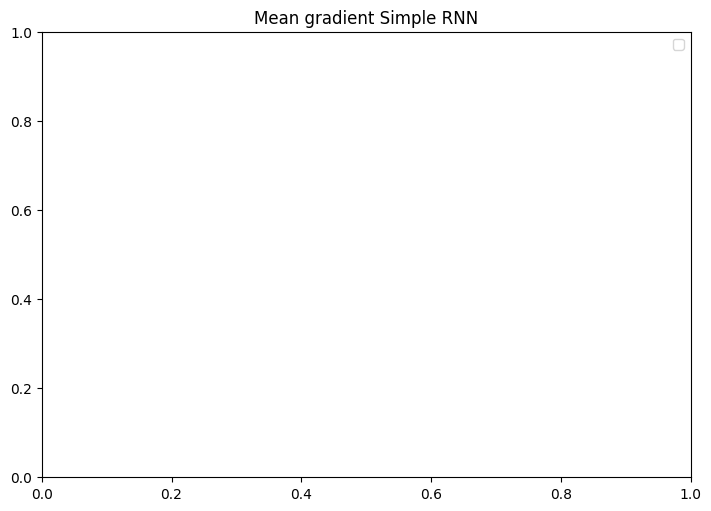

In [11]:
# Exploding Gradient
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
npt_exp = neptune.init(    
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzOTM1NWZiMC05OTkwLTRlNmQtOTcxMi05ODc5NWIwZGRiMTkifQ==",
    project=myProject, 
    name='SimpleRNN', 
    tags=['vanishingGradients'])

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(SimpleRNN(128, activation='relu'))  
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
opt = Adam(learning_rate=0.5)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])

print("Train...")
curGradHist, curLossHist, curWgtHist = fitModel(X_test, y_test, model, optimizer=opt, npt_exp=npt_exp)
npt_exp['Comparing All Layers'].upload(neptune.types.File.as_image(gradientsVis(curGradHist, curLossHist, 
                                                                                    modelName='Simple RNN')))
npt_exp.stop()
